# **Create synthetic data for Random Forest Regressor**

The goal is to test different hyperparameter tuning techniques, i.e. Grid Search, Automated Hyperparameter Tuning and Bayesian Optimization. The three techniques performance are then compared in terms of RMSE and time of execution.

A sinusoide with additive gaussian noise is generated.

In [6]:
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate synthetic data (simple linear function with noise)
np.random.seed(42)
X = np.sort(5 * np.random.rand(500, 1), axis=0)  # Features
# y = 2 * X.ravel() + np.random.normal(0, 1, X.shape[0])  # Target with some noise
y = 5 * np.sin(3*X).ravel() + np.random.normal(0, 1, X.shape[0])

Create train and test sets using a random split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Grid Search**

Create metamodel (Random Forset Regression) and define hyperparameters:

In [8]:
# Define the Random Forest Regressor model
rf = RandomForestRegressor(random_state=42)

# Define a small hyperparameter grid for tuning
hyperparam_grid = {
    "n_estimators": np.linspace(10, 200, num=5, dtype=int),  # Generates [70, 75, 79, 80, 85]
    "max_depth": np.linspace(5, 30, num=3, dtype=int),       # Generates [8, 9, 10]
    "min_samples_split": np.linspace(2, 20, num=3, dtype=int),  # Generates [6, 8, 10]
    "min_samples_leaf": np.linspace(1, 10, num=3, dtype=int)     # Generates [4, 5, 6]
}

Define hyperparameter tuning technique (Grid Search):

In [9]:
# Start timing
start_time = time.time()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(rf, hyperparam_grid, cv=3, scoring="neg_mean_squared_error") # cv=3 : 3-folds cross-validation
grid_search.fit(X_train, y_train)

# Get the best estimator after Grid Search
best_rf_grid = grid_search.best_estimator_

# Print the best model and its parameters
print("Best model found by Grid Search:")
print(best_rf_grid)

# Predict with the best model
y_pred_grid = best_rf_grid.predict(X_test)

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Evaluate the model performance
mse_grid = mean_squared_error(y_test, y_pred_grid)
print(f"Mean Squared Error on the test set: {mse_grid}")

Best model found by Grid Search:
RandomForestRegressor(max_depth=17, min_samples_leaf=5, n_estimators=200,
                      random_state=42)
Execution time: 54.26 seconds
Mean Squared Error on the test set: 1.125300018845828


Plot predicted model:

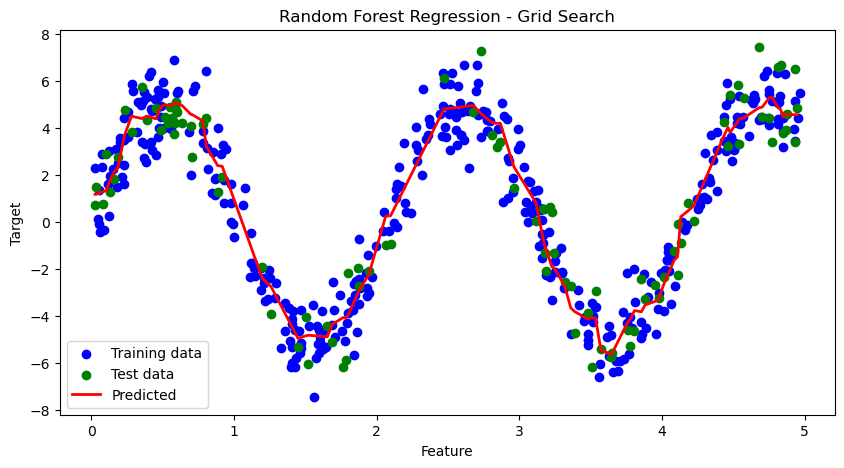

In [10]:
# Plot the results with a curve for predictions
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, color='blue', label="Training data")
plt.scatter(X_test, y_test, color='green', label="Test data")

# Sort X_test and corresponding predictions for smooth curve plotting
sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sorted_indices]
y_pred_grid_sorted = y_pred_grid[sorted_indices]

# Plot the prediction curve
plt.plot(X_test_sorted, y_pred_grid_sorted, color='red', label="Predicted", linewidth=2)
plt.legend()
plt.title("Random Forest Regression - Grid Search")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

# **Automated Hyperparameter Tuning : Optuna**

If needed:

In [11]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


Define metamodel (Random Forest Regression) and hyperparameter technique (Optuna):

In [12]:
import numpy as np
import time
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    # Define the model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Perform cross-validation
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring="neg_mean_squared_error")
    return -scores.mean()

# Start timing
start_time = time.time()

# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

# Train the model with the best hyperparameters
best_rf_optuna = RandomForestRegressor(**best_params, random_state=42)
best_rf_optuna.fit(X_train, y_train)

# Predict with the best model
y_pred_optuna = best_rf_optuna.predict(X_test)

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Evaluate the model performance
mse_optuna = mean_squared_error(y_test, y_pred_optuna)
print(f"Mean Squared Error on the test set: {mse_optuna}")

[I 2024-11-05 22:05:43,925] A new study created in memory with name: no-name-c6f7238a-2e1c-4e58-a703-f55babc3a322
[I 2024-11-05 22:05:44,210] Trial 0 finished with value: 1.3260060310925705 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.3260060310925705.
[I 2024-11-05 22:05:44,875] Trial 1 finished with value: 1.3261136912680032 and parameters: {'n_estimators': 175, 'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 0 with value: 1.3260060310925705.
[I 2024-11-05 22:05:45,270] Trial 2 finished with value: 1.460005172919059 and parameters: {'n_estimators': 104, 'max_depth': 22, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 0 with value: 1.3260060310925705.
[I 2024-11-05 22:05:45,324] Trial 3 finished with value: 1.3655981143717082 and parameters: {'n_estimators': 11, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 7}. Best is trial 0 with valu

Best hyperparameters found by Optuna:
{'n_estimators': 142, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4}
Execution time: 26.33 seconds
Mean Squared Error on the test set: 1.1465867215395322


Plot:

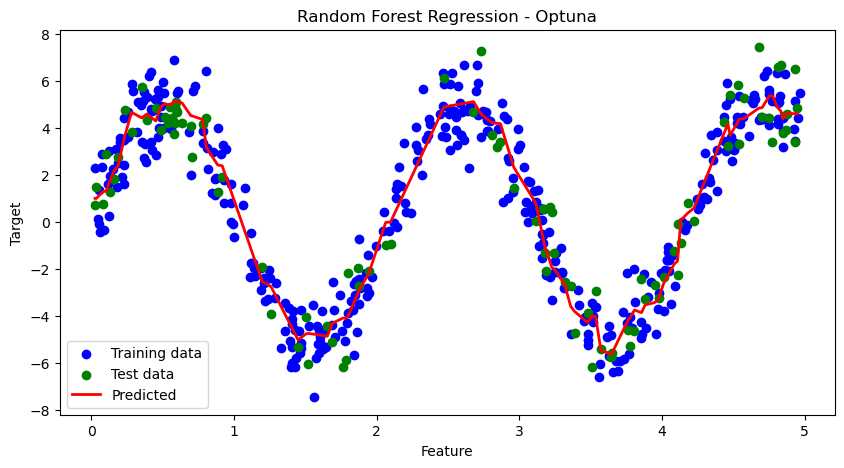

In [13]:
# Plot the results with a curve for predictions
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, color='blue', label="Training data")
plt.scatter(X_test, y_test, color='green', label="Test data")

# Sort X_test and corresponding predictions for smooth curve plotting
sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sorted_indices]
y_pred_optuna_sorted = y_pred_optuna[sorted_indices]

# Plot the prediction curve
plt.plot(X_test_sorted, y_pred_optuna_sorted, color='red', label="Predicted", linewidth=2)
plt.legend()
plt.title("Random Forest Regression - Optuna")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

# **Bayesian Optimization**

If needed:

In [14]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


Define metamodel (Random Forest Regression) and hyperparameter technique (Bayesian Optimization):

In [15]:
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from bayes_opt import BayesianOptimization

# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    # Convert parameters to integers for the model
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    # Create the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return np.mean(scores)

# Define the parameter space
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 30),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

# Start timing
start_time = time.time()

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=30)

# Get the best parameters
best_params = optimizer.max['params']
best_params = {key: int(value) for key, value in best_params.items()}
print("Best hyperparameters found:")
print(best_params)

# Train the model with the best parameters
best_rf_bayesian = RandomForestRegressor(**best_params, random_state=42)
best_rf_bayesian.fit(X_train, y_train)

# Predict with the best model
y_pred_bayesian = best_rf_bayesian.predict(X_test)

# End timing
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Evaluate the model performance
mse_bayesian = mean_squared_error(y_test, y_pred_bayesian)
print(f"Mean Squared Error on the test set: {mse_bayesian}")

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -1.39     | 14.36     | 9.556     | 15.18     | 139.8     |
| 2         | -1.301    | 8.9       | 2.404     | 3.046     | 179.9     |
| 3         | -1.314    | 20.03     | 7.373     | 2.371     | 195.5     |
| 4         | -1.345    | 25.81     | 2.911     | 5.273     | 77.51     |
| 5         | -1.291    | 12.61     | 5.723     | 9.775     | 93.68     |
| 6         | -1.316    | 20.3      | 2.255     | 7.259     | 105.0     |
| 7         | -1.332    | 16.4      | 8.067     | 5.594     | 127.1     |
| 8         | -1.347    | 19.81     | 1.418     | 12.94     | 75.58     |
| 9         | -1.399    | 6.626     | 9.54      | 19.38     | 171.3     |
| 10        | -1.35     | 12.62     | 1.879     | 14.32     | 116.0     |
| 11        | -1.392    | 17.52     | 9.833     | 3.753     | 95.46     |
| 12        | -1.382    | 6.23      | 

Plot:

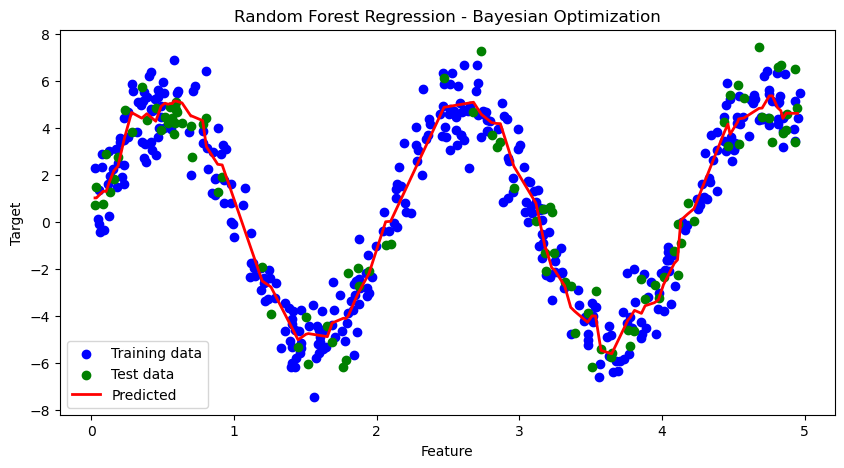

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, color='blue', label="Training data")
plt.scatter(X_test, y_test, color='green', label="Test data")

# Sort X_test and corresponding predictions for smooth curve plotting
sorted_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sorted_indices]
y_pred_bayesian_sorted = y_pred_bayesian[sorted_indices]

plt.plot(X_test_sorted, y_pred_bayesian_sorted, color='red', label="Predicted", linewidth=2)
plt.legend()
plt.title("Random Forest Regression - Bayesian Optimization")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

# **Cross-validation Analysis**

In [17]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_rf_optuna, best_rf_grid, and best_rf_bayesian are trained models
models = {
    'Grid Search RF': best_rf_grid,        # Replace with your grid search model
    'Optuna RF': best_rf_optuna,                  # The Optuna-tuned model
    'Bayesian RF': best_rf_bayesian        # Replace with your Bayesian model
}

# Compute cross-validation scores for each model
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_results[name] = -scores  # Convert negative MSE to positive for easier interpretation
    print(f"{name}: Mean MSE = {np.mean(-scores):.4f}, Std = {np.std(-scores):.4f}")

Grid Search RF: Mean MSE = 1.2545, Std = 0.1224
Optuna RF: Mean MSE = 1.2573, Std = 0.1411
Bayesian RF: Mean MSE = 1.2561, Std = 0.1406


Plot:

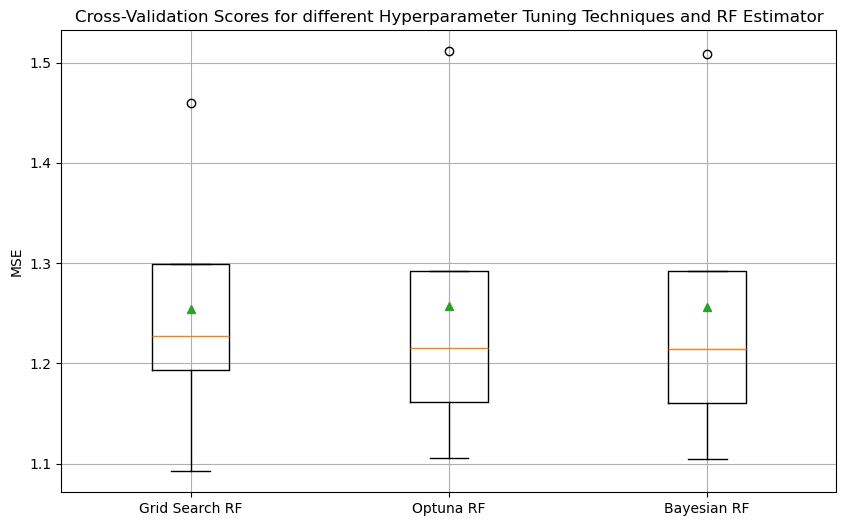

In [18]:
# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), showmeans=True)
plt.title("Cross-Validation Scores for different Hyperparameter Tuning Techniques and RF Estimator")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

**Comments:** the green triangles are the mean MSE, the horizontal lines are the mediam MSE, the boxes represent the interquartile range (IQR), which is the range that covers the middle 50% of the scores. The mean MSE are almost the same, but Optuna shows larger IQR, suggesting that its performance varies more significantly across different training and testing splits. Hence, the model might be sensitive to the specific data split or might have some overfitting or underfitting issues. However, Optuna is the one that has the lowest execution time.

Execution time for different hyp tuning tech:
- Grid : 54.26 s
- Optuna : 26.33 s
- Bayesian : 41.22 s

# **Complexity and Performance Trade-Off**

In [19]:
import matplotlib.pyplot as plt

# Extracting the best hyperparameters from each model
best_params_grid = {
    'n_estimators': best_rf_grid.get_params()['n_estimators'],
    'max_depth': best_rf_grid.get_params()['max_depth']
}
best_params_optuna = {
    'n_estimators': best_rf_optuna.get_params()['n_estimators'],
    'max_depth': best_rf_optuna.get_params()['max_depth']
}
best_params_bayesian = {
    'n_estimators': best_rf_bayesian.get_params()['n_estimators'],
    'max_depth': best_rf_bayesian.get_params()['max_depth']
}

# Assuming you have the MSEs for each model
# Replace these variables with your actual MSE values if needed
mse_grid = mean_squared_error(y_test, y_pred_grid)
mse_optuna = mean_squared_error(y_test, y_pred_optuna)
mse_bayesian = mean_squared_error(y_test, y_pred_bayesian)

Plot:

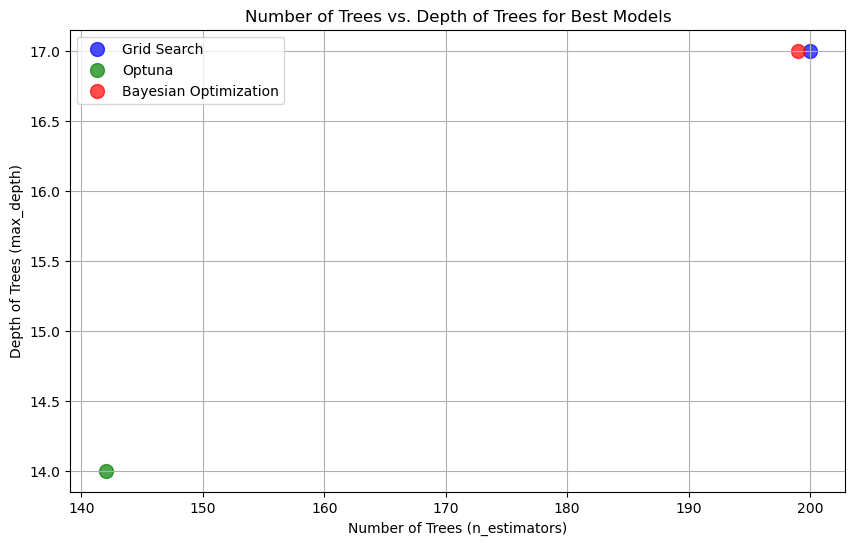

In [20]:
# Plot the number of trees vs. depth of trees for each model
plt.figure(figsize=(10, 6))

# Plot the best parameters for each model
plt.scatter(
    best_params_grid['n_estimators'], best_params_grid['max_depth'],
    color='blue', label='Grid Search', s=100, alpha=0.7
)
plt.scatter(
    best_params_optuna['n_estimators'], best_params_optuna['max_depth'],
    color='green', label='Optuna', s=100, alpha=0.7
)
plt.scatter(
    best_params_bayesian['n_estimators'], best_params_bayesian['max_depth'],
    color='red', label='Bayesian Optimization', s=100, alpha=0.7
)

# Labels and title
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Depth of Trees (max_depth)')
plt.title('Number of Trees vs. Depth of Trees for Best Models')
plt.legend()
plt.grid(True)

plt.show()

**Comments:** Grid search is the model with the highest complexity, but with highest simulation time.